# Analysis of stock value of YPF
## Version: 1
## Author: Alexis Biancotti
## Date: 08/2020

## Imports

In [240]:
import pandas as pd
from pandas import DataFrame
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import interpolate
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import functools
import math

## Functions

In [241]:
# function of the two variables regression
def func_v2(X, m1, m2):
    x1,x2,y0 = X
    val1 = m1*x1 + m2*x2 + y0
    return (val1)

# function of the three variables regression
def func_v3(X, m1, m2, m3):
    x1,x2,x3,y0 = X
    val1 = m1*x1 + m2*x2 + m3*x3 + y0
    return (val1)

# function that calculates the r squared error
def r_squared_error(y_real, y_est):
    residuals = y_real - y_est
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_real-np.mean(y_real))**2)
    return (1 - (ss_res / ss_tot))

# function that calcalutes and replace outliers
def outliers_cleaning(target):

    outlier = target.quantile(0.75) + (target.quantile(0.75) - target.quantile(0.25))*1.5

    target_procesed = target*1
    
    analysis = target_procesed.loc[target_procesed > outlier]
    
    if len(analysis)>0:
        target_procesed.loc[target > outlier] = np.nan
        target_procesed = target_procesed.interpolate(method='spline',order=3, limit=10, limit_direction='both')
    else:
        analysis = 'No existing outliers'
    
    return analysis,outlier,target_procesed

## Data Preparation

In [242]:
# csv reading
data_ypf      = pd.read_csv('YPFD.BA.csv')
data_dolar    = pd.read_csv('DOLAR.csv')
data_merval   = pd.read_csv('MERVAL.BA.csv')
data_petroleo = pd.read_csv('PETROLEO.csv')

In [243]:
# date format
data_ypf['Date']      = pd.to_datetime(data_ypf.Date)
data_petroleo['Date'] = pd.to_datetime(data_petroleo.Date)
data_merval['Date']   = pd.to_datetime(data_merval.Fecha,dayfirst=True)
data_dolar['Date']    = pd.to_datetime(data_dolar.indice_tiempo)

# set index and leaving values from 2017
data_ypf.set_index('Date',inplace=True)
data_ypf = data_ypf.loc['2017-01-01':'2020-06-30'].rename(columns={"Close": "YPF"})

data_petroleo.set_index('Date',inplace=True)
data_petroleo = data_petroleo.loc['2017-01-01':'2020-06-30'].rename(columns={"Close": "PETROLEO"})

data_merval.set_index('Date',inplace=True)
data_merval = data_merval.sort_index()
data_merval = data_merval.loc['2017-01-01':'2020-06-30'].rename(columns={"Apertura": "MERVAL"})

data_dolar.set_index('Date',inplace=True)
data_dolar = data_dolar.loc['2017-01-01':'2020-06-30']

# I drop the columns that i dont need in the model
data_ypf      = data_ypf.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
data_petroleo = data_petroleo.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
data_merval   = data_merval.drop(columns=['Fecha', 'Último', 'Máximo', 'Mínimo', 'Vol.', '% var.'])
data_dolar    = data_dolar.loc[:,'tipo_cambio_bna_vendedor'].to_frame().rename(columns={"tipo_cambio_bna_vendedor":
                                                                                        "DOLAR"})

In [244]:
# join all tables into one and looking for "Nan"
data = data_ypf.join(data_dolar, how='left')
data = data.join(data_merval, how='left')
data = data.join(data_petroleo, how='left')

print(data.head())
print(data.isna().sum())

                   YPF  DOLAR     MERVAL   PETROLEO
Date                                               
2017-01-02  273.000000   16.1  16.921,64        NaN
2017-01-03  275.000000   16.1  17.526,34  52.330002
2017-01-04  273.000000   16.3  17.915,30  53.259998
2017-01-05  270.000000   16.2  18.233,95  53.759998
2017-01-06  273.850006   16.1  18.226,59  53.990002
YPF          0
DOLAR        0
MERVAL       3
PETROLEO    29
dtype: int64


In [245]:
# to solve the NaN issue I will replace these values with a cubic interpolation
data['PETROLEO'] = data.loc[:,'PETROLEO'].interpolate(method='spline',order=3, limit=10, limit_direction='both')

# because the merval type is a string, i will trim it and convert it to a int
merval_str = data['MERVAL'].str.split(',').str[0]
merval_str = merval_str.str.split('.').str[0]+merval_str.str.split('.').str[1]
merval_str = merval_str.astype(float)
data['MERVAL'] = merval_str.interpolate(method='spline',order=3, limit=10, limit_direction='both')

print(data.head())
print(data.isna().sum())

                   YPF  DOLAR   MERVAL   PETROLEO
Date                                             
2017-01-02  273.000000   16.1  16921.0  53.036106
2017-01-03  275.000000   16.1  17526.0  52.330002
2017-01-04  273.000000   16.3  17915.0  53.259998
2017-01-05  270.000000   16.2  18233.0  53.759998
2017-01-06  273.850006   16.1  18226.0  53.990002
YPF         0
DOLAR       0
MERVAL      0
PETROLEO    0
dtype: int64


# Data Exploration

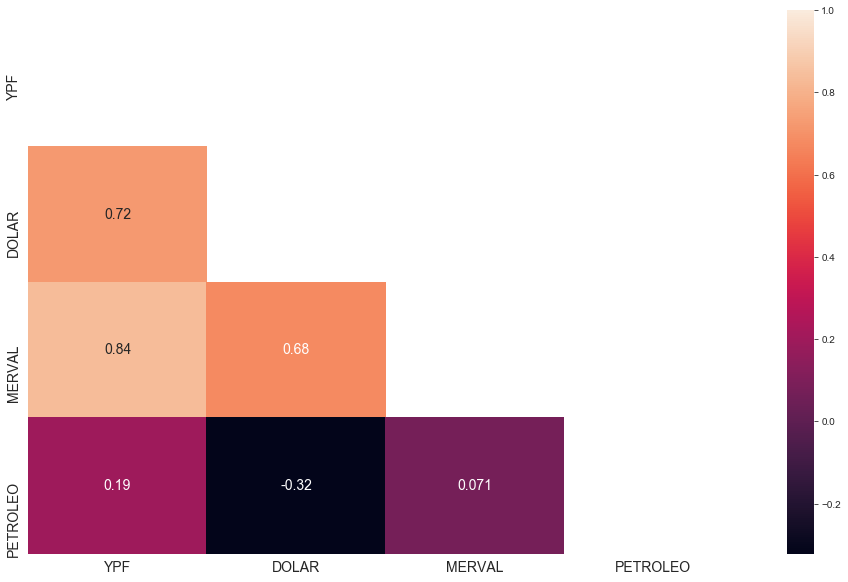

In [246]:
# correlation plot of the values from the table
mask = np.zeros_like(data.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

plt.figure(figsize=(16,10))
sns.heatmap(data.corr(), mask=mask, annot=True, annot_kws={"size": 14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either i

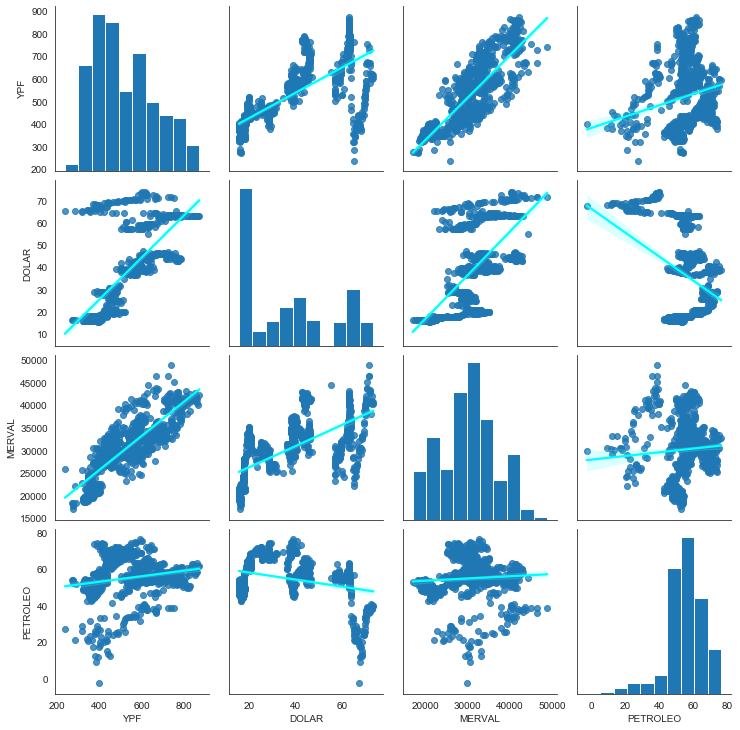

In [247]:
sns.pairplot(data, kind='reg', plot_kws={'line_kws':{'color': 'cyan'}})
plt.show()

In [248]:
fig = px.line(data, x=data.index, y="YPF", title='Stock Value of YPF')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

## Data Regression Preparation

In [249]:
# "y" values with natural logarithm to linearize the values and make a slightly deinflation
ypf_log        = np.log(data['YPF'].loc['2019-07-01':'2020-05-15'])

ypf_intercept_log = ypf_log[-1]

# new dataframe with the "x" values for the regression
data_transformed = data.loc['2019-07-01':'2020-05-15']
data_transformed = data_transformed.drop(['YPF','PETROLEO'], axis=1)
data_transformed = np.log(data_transformed)

# making a transformation to force the intercept as the last value of the table 
data_transformed['DOLAR']    = data_transformed['DOLAR'] - data_transformed['DOLAR'][-1]

data_transformed['MERVAL']   = data_transformed['MERVAL'] - data_transformed['MERVAL'][-1]

data_transformed['X']        = data_transformed.index.astype(int) * 1e-9/86400 

data_transformed['X']        = data_transformed['X'] - data_transformed['X'][-1]
# note: if i want to convert the index I could sum +25569 and the result is the date converted to int 

#--------YPF y X----------
ypf_train             = data.YPF.loc['2019-07-01':'2020-05-15']
ypf_test              = data.YPF.loc['2020-05-15':]
test_x                = np.arange(0, len(ypf_test), step=1)

#--------DOLAR----------
dolar_test            = np.log(data.DOLAR.loc['2020-05-15':])
dolar_test            = dolar_test - dolar_test[0]

#--------MERVAL----------
merval_test            = np.log(data.MERVAL.loc['2020-05-15':])
merval_test            = merval_test - merval_test[0]

# data spliting to prevent overfitting
data_logged_train, data_logged_test, ypf_logged_train, ypf_logged_test = train_test_split(data_transformed, ypf_log, 
                                                                                            test_size=0.3, random_state=10)

## Regression

## Two Variables

## $$ y = m1*x1 + m2*x2 + y0 $$
## $$ x1= date,\quad x2= dolar,\quad y0= intercept $$

In [250]:
# initial guesses for x1 and x2
p0_v2 = 6., 1.
   
popt_v2, pcov_v2 = curve_fit(func_v2, (data_logged_train.X, data_logged_train.DOLAR, ypf_intercept_log), (ypf_logged_train),
                             p0_v2)

In [251]:
# I use the function with the calculated coefficients
regr_v2 = np.exp(func_v2((data_logged_train.X, data_logged_train.DOLAR, ypf_intercept_log), popt_v2[0], popt_v2[1])).sort_index()

pred_v2 = np.exp(func_v2((test_x, dolar_test, ypf_intercept_log), popt_v2[0], popt_v2[1])).sort_index()

## Three Variables

## $$ y = m1*x1 + m2*x2 + m3*x3 + y0 $$
## $$ x1= date,\quad x2= dolar,\quad x3= merval ,\quad y0= intercept $$

In [252]:
# initial guesses for x1, x2 and x3
p0_v3 = 6., 1., 1.
   
popt_v3, pcov_v3 = curve_fit(func_v3,
                             (data_logged_train.X, data_logged_train.DOLAR, data_logged_train.MERVAL, ypf_intercept_log),
                             (ypf_logged_train),
                             p0_v3
                             )

In [253]:
# I use the function with the calculated coefficients
regr_v3 = np.exp(func_v3((data_logged_train.X, data_logged_train.DOLAR, data_logged_train.MERVAL, ypf_intercept_log),
               popt_v3[0], popt_v3[1], popt_v3[2])).sort_index()

pred_v3 = np.exp(func_v3((test_x, dolar_test, merval_test, ypf_intercept_log), popt_v3[0], popt_v3[1], popt_v3[2])).sort_index()

## Data Visualization

In [254]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=regr_v2.index, y=regr_v2,
                    mode='lines',
                    name='Regr_v2'))

fig.add_trace(go.Scatter(x=pred_v2.index, y=pred_v2,
                    mode='lines',
                    name='Pred_v2'))

fig.add_trace(go.Scatter(x=regr_v3.index, y=regr_v3,
                    mode='lines',
                    name='Regr_v3'))

fig.add_trace(go.Scatter(x=pred_v3.index, y=pred_v3,
                    mode='lines',
                    name='Pred_v3'))

fig.add_trace(go.Scatter(x=data.loc['2019-07-01':].index, y=data['YPF'].loc['2019-07-01':],
                    mode='lines',
                    name='Real Values'))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)


fig.show()

## Statistical Analysis and Improvements

In [255]:
print('The r squared error of the regr_v2 is: ', r_squared_error(np.exp(ypf_logged_train),regr_v2))
print('The r squared error of the regr_v3 is: ', r_squared_error(np.exp(ypf_logged_train),regr_v3))
print('The r squared error of the pred_v2 is: ', r_squared_error(ypf_test,pred_v2))
print('The r squared error of the pred_v3 is: ', r_squared_error(ypf_test,pred_v3))

The r squared error of the regr_v2 is:  0.1039976110597094
The r squared error of the regr_v3 is:  0.630825691300452
The r squared error of the pred_v2 is:  -3.4336519492446946
The r squared error of the pred_v3 is:  -0.9596742360313928


After this quick analysis we can see that the first model (regr_v2) doesnt work too well and the regr_v3 have a relative
good fit of train values, wich can be improved. But in the test data the fit is worst than the mean, in the following graph 
we can see it more clearly

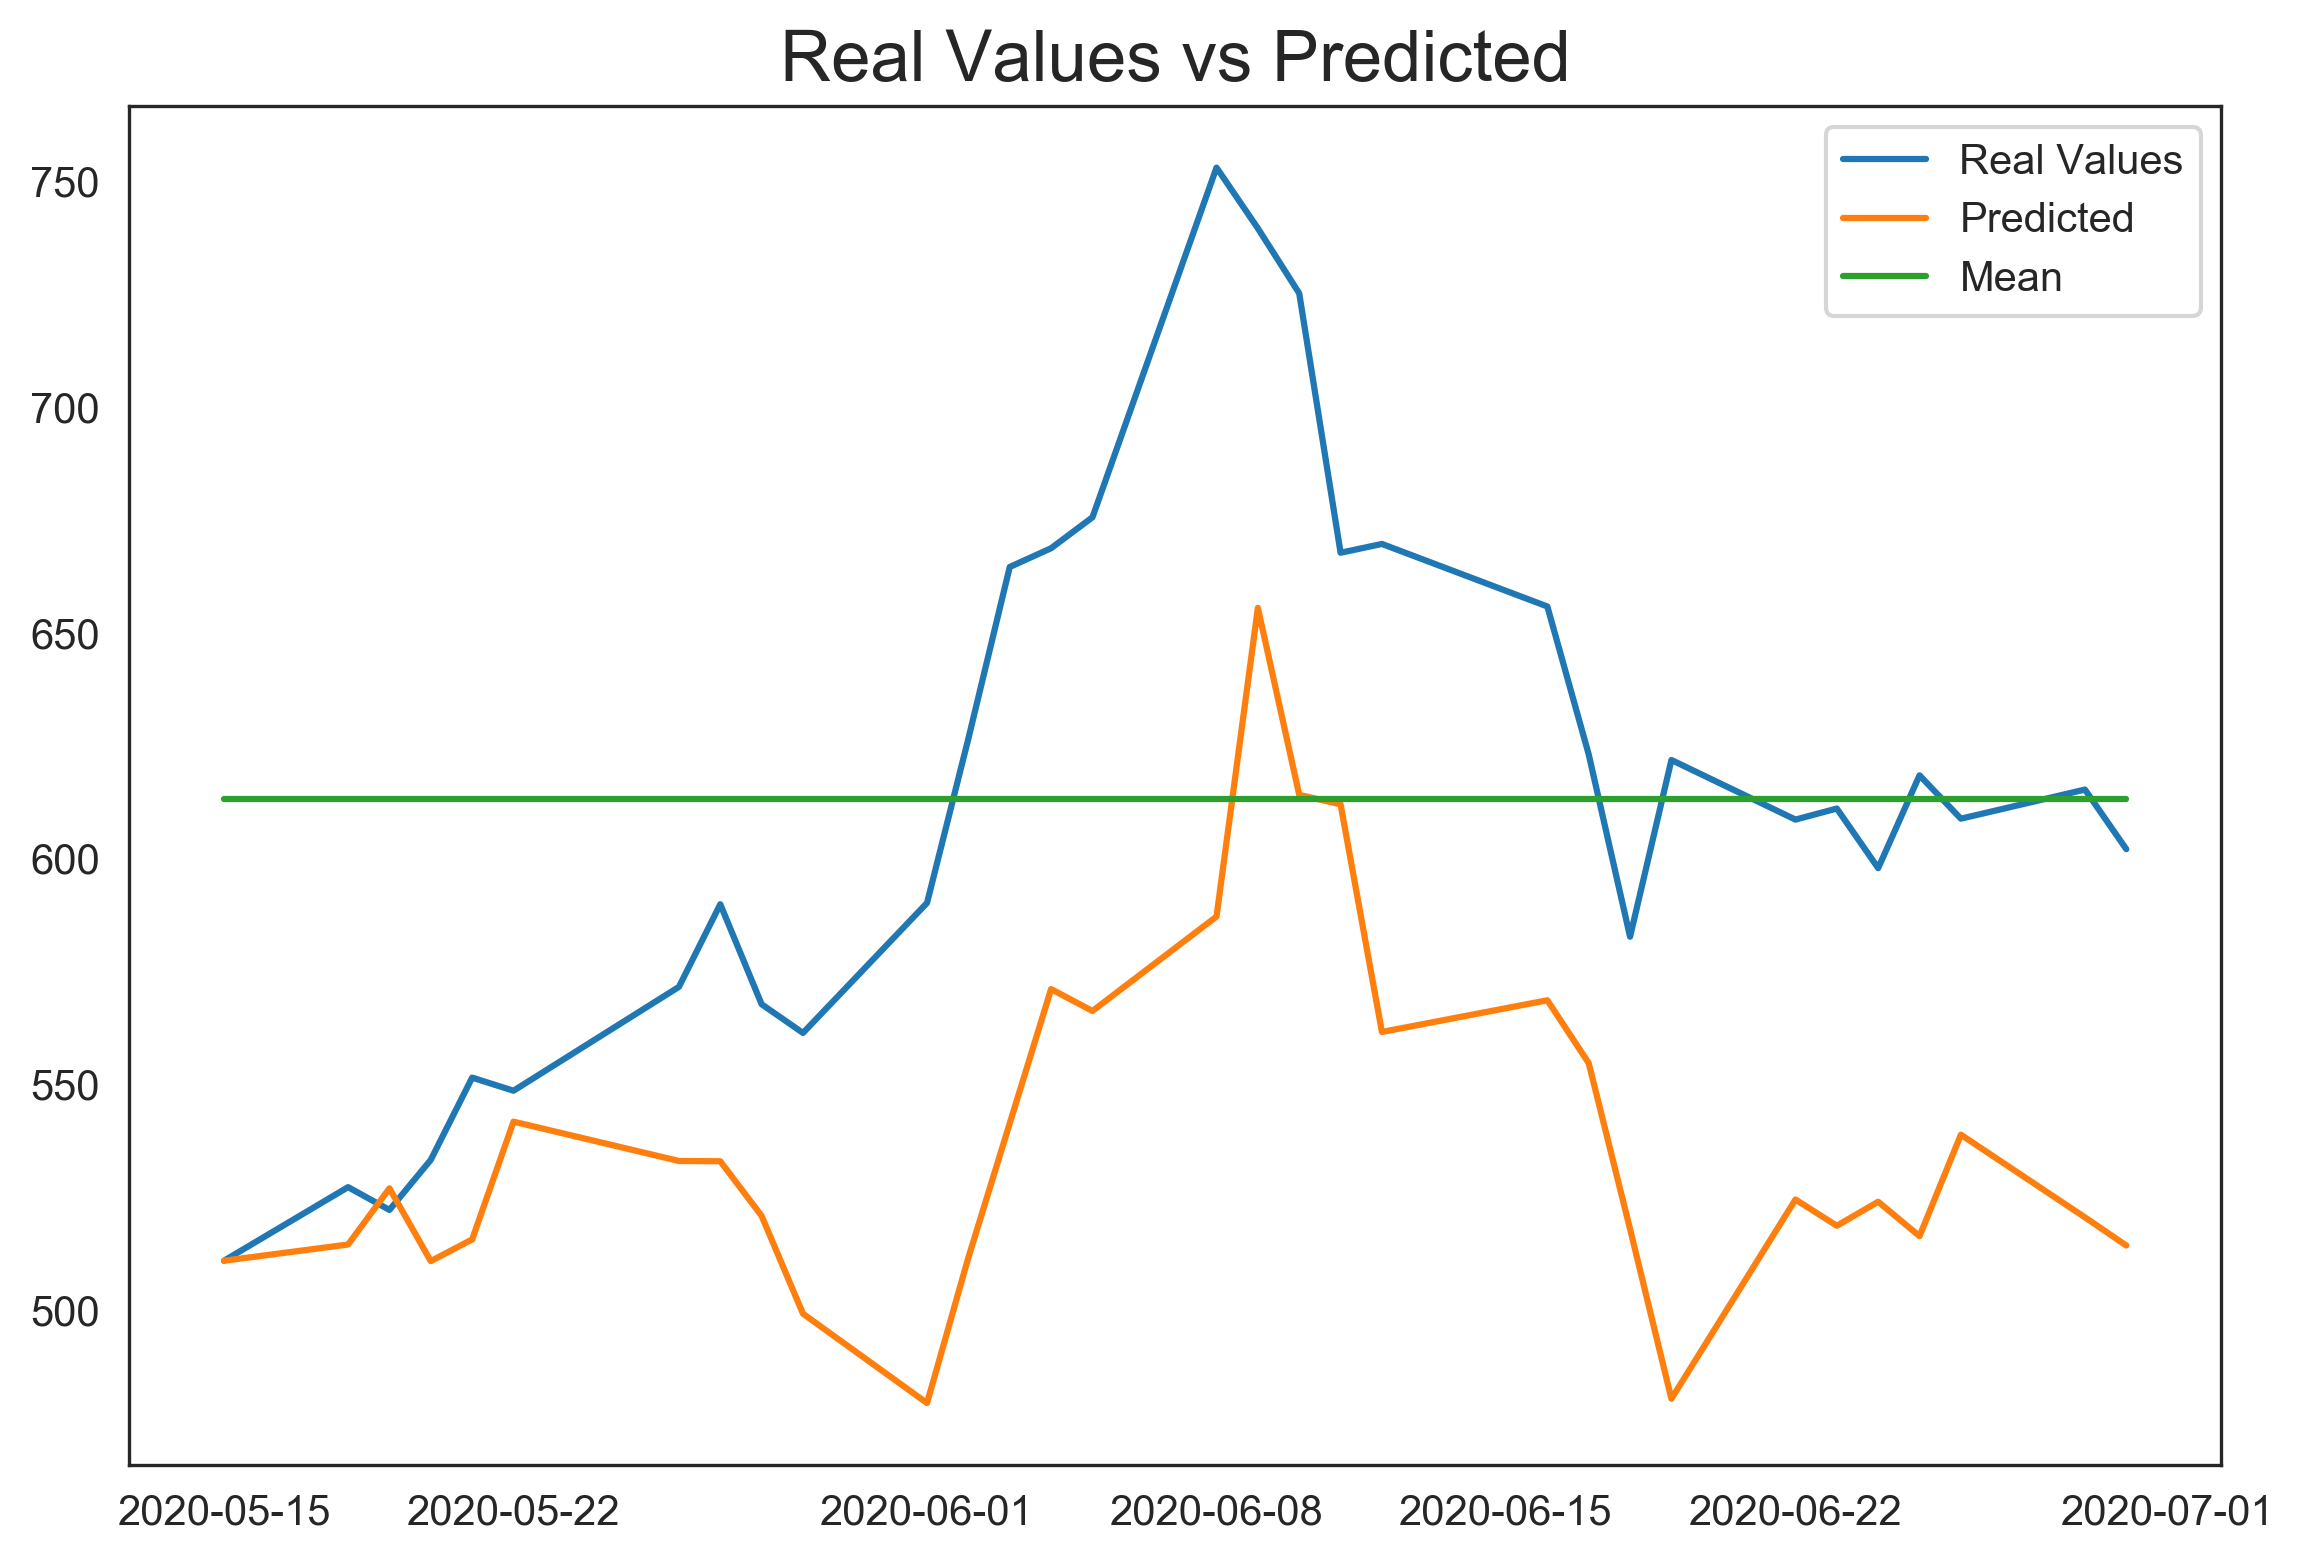

In [256]:
plt.figure(figsize=(9, 6), dpi=300)
plt.plot(ypf_test.index, ypf_test)
plt.plot(pred_v3.index, pred_v3)
plt.plot(ypf_test.index, np.ones(len(ypf_test))*np.mean(ypf_test))
plt.title('Real Values vs Predicted', fontsize=17)
plt.legend(['Real Values','Predicted','Mean'])
plt.show()

The regression had copied the form of the real values but not his magnitude, for this reason and because the fitted values are worst than the mean line the r squared was a negative value. Furthermore we can see in the chart of data visualization that exist a upward trend, previous to the test data. We can prove this calculating the secant line that pass through the first point of may and the last of the train data

In [257]:
ypf_trend   = data.loc['2020-05-01':'2020-05-15'].YPF
ypf_trend_x = np.arange(0, len(ypf_trend), step=1)

ypf_trend_slope = (ypf_trend[-1] - ypf_trend[0])/(len(ypf_trend)-1)

print('The slope of the secant is:',ypf_trend_slope)

The slope of the secant is: 10.150000666666674


In [258]:
# I will add this trend to the original prediction with a weight assigned and check if the r squared improves
pred_v3_trend = pred_v3+test_x*ypf_trend_slope*0.5

print('The r squared error of the pred_v3 is: ', r_squared_error(ypf_test,pred_v3_trend))

The r squared error of the pred_v3 is:  0.5749683763370514


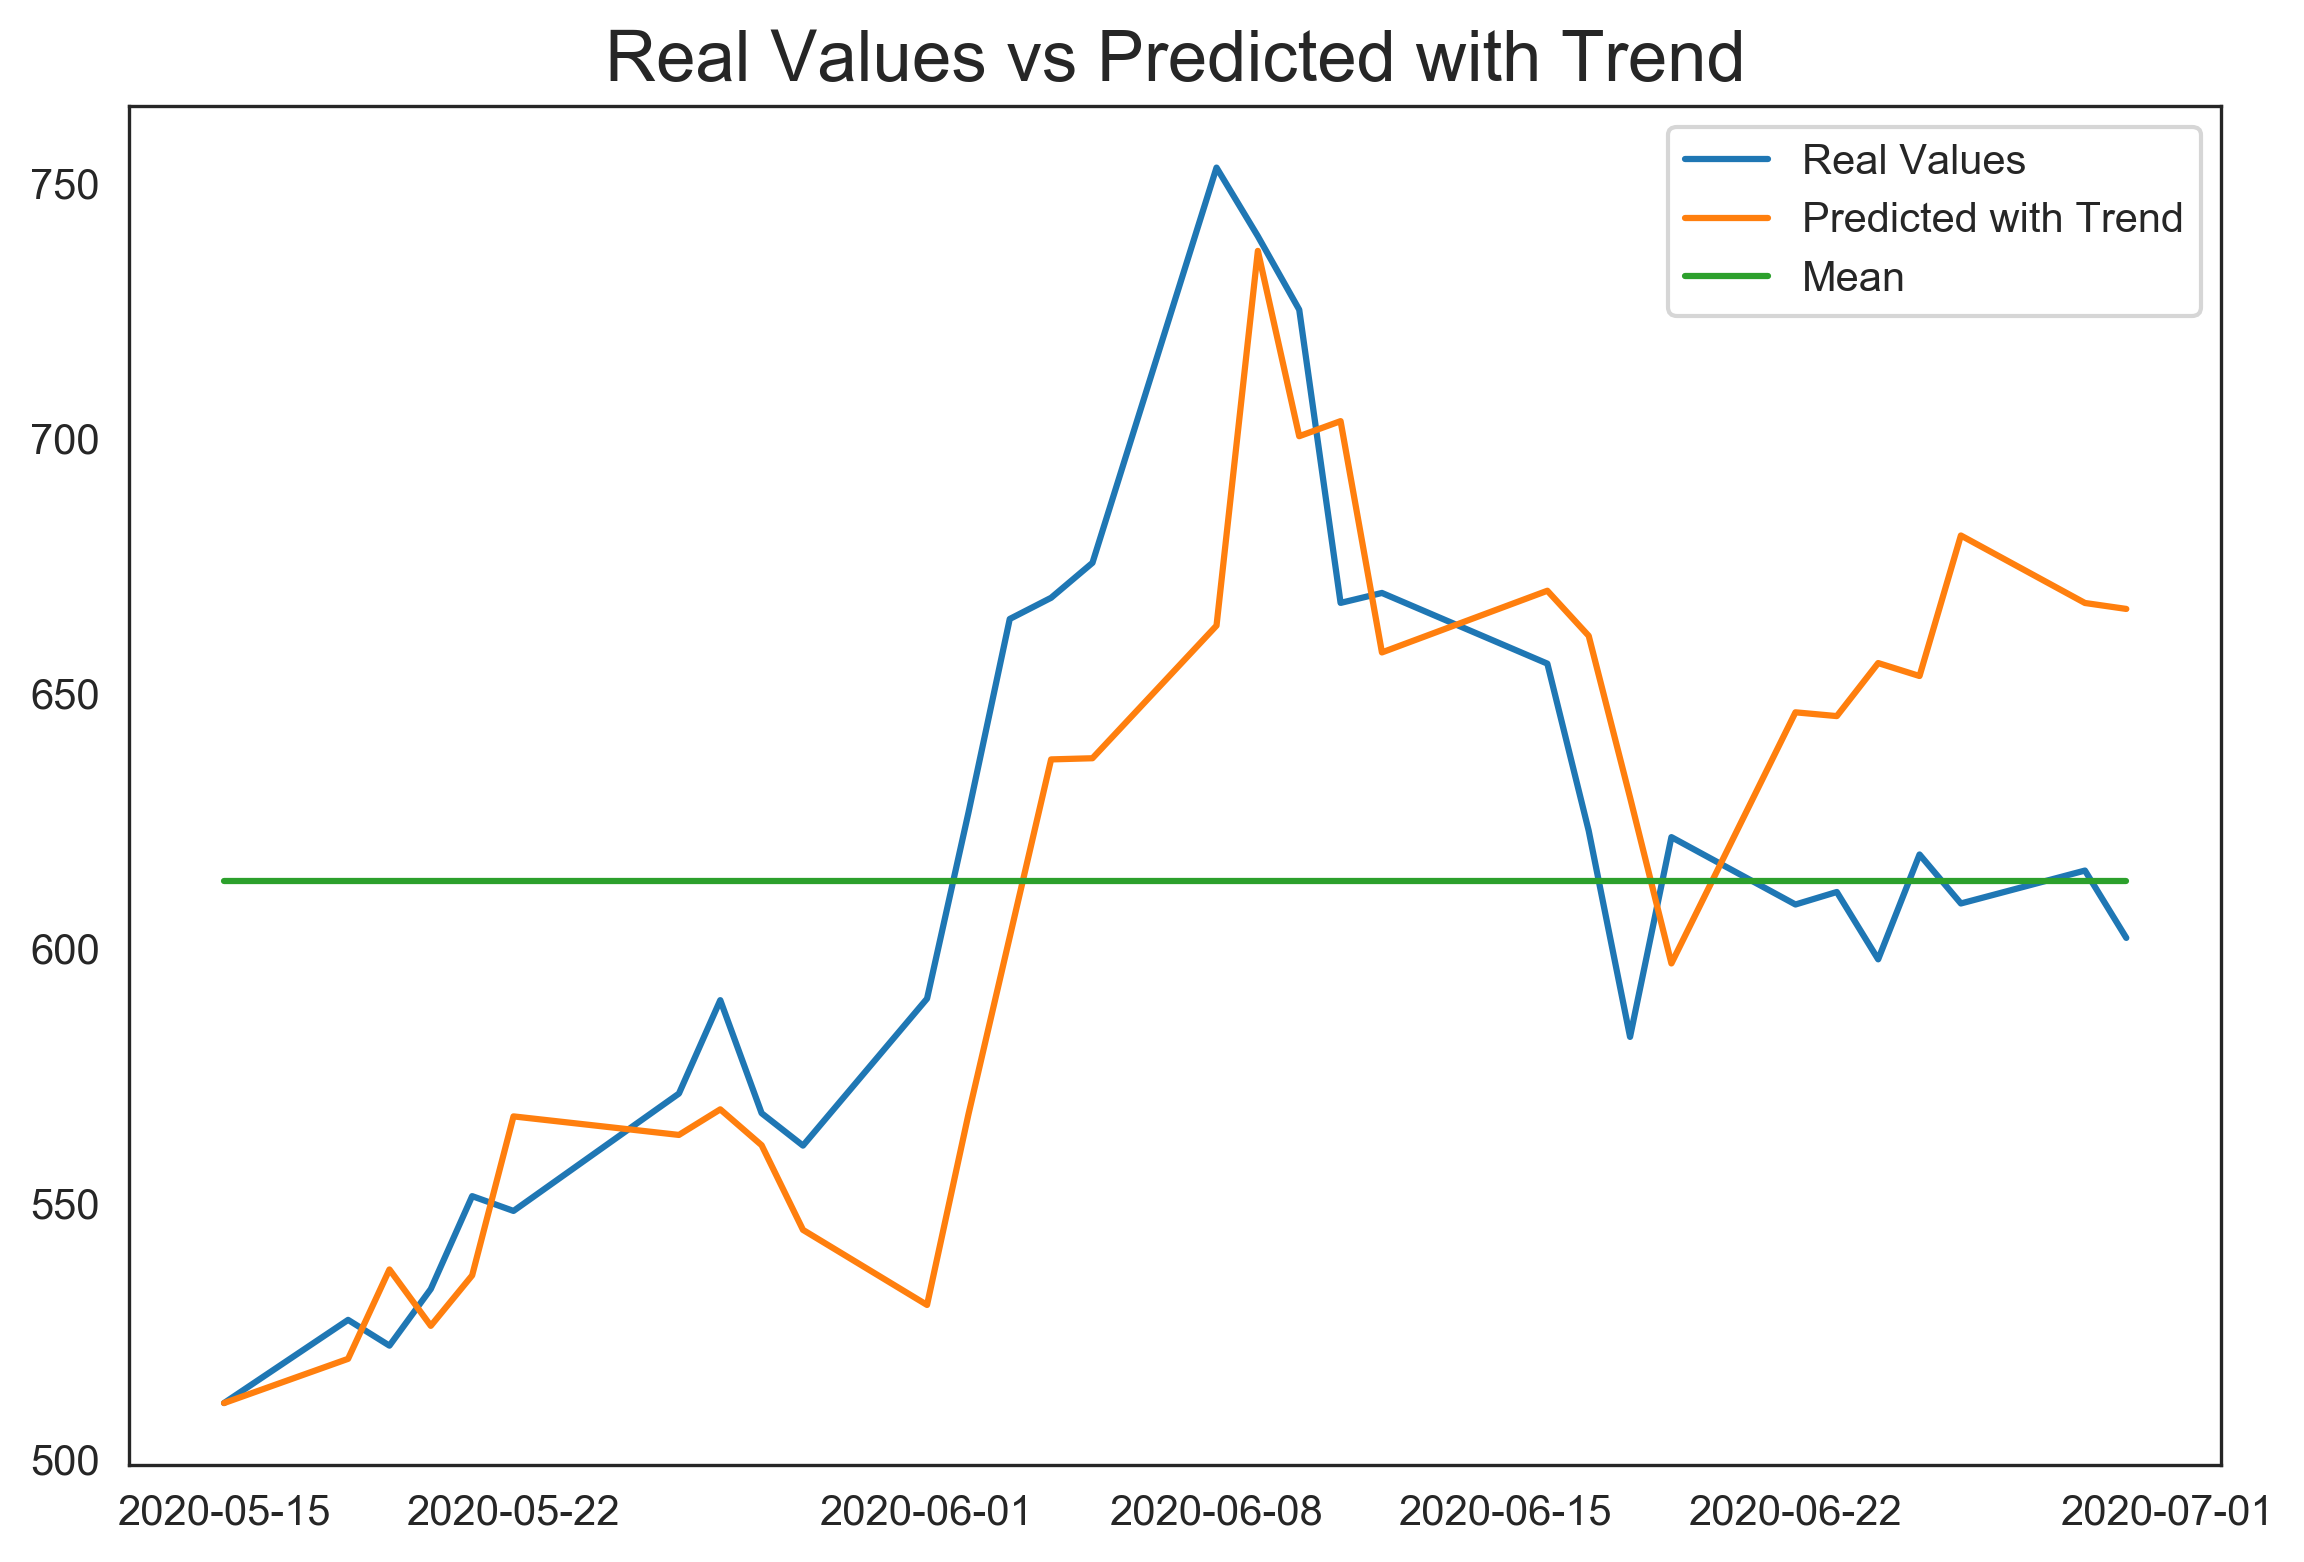

In [259]:
plt.figure(figsize=(9, 6), dpi=300)
plt.plot(ypf_test.index, ypf_test)
plt.plot(pred_v3.index, pred_v3_trend)
plt.plot(ypf_test.index, np.ones(len(ypf_test))*np.mean(ypf_test))
plt.title('Real Values vs Predicted with Trend', fontsize=17)
plt.legend(['Real Values','Predicted with Trend','Mean'])
plt.show()

Another improvement that we can make is look for inussual values in the regression and the prediction using outliers detection. This can solve particular conflictive points in our model 

In [260]:
analysis_regr ,regr_outlier_condition , regr_outlier_treated = outliers_cleaning(regr_v3)
analysis_pred ,pred_outlier_condition , pred_outlier_treated = outliers_cleaning(pred_v3_trend)

In [261]:
print('A value is a outlier in the regression if it´s bigger than: ', round(regr_outlier_condition,2))
print('A value is a outlier in the prediction if it´s bigger than: ', round(pred_outlier_condition,2))
print('The following valeus were outliers in the regression: ')
print(analysis_regr)
print('The following valeus were outliers in the prediction: ')
print(analysis_pred)

A value is a outlier in the regression if it´s bigger than:  1040.89
A value is a outlier in the prediction if it´s bigger than:  812.02
The following valeus were outliers in the regression: 
Date
2019-08-12    1110.993038
dtype: float64
The following valeus were outliers in the prediction: 
No existing outliers


## Regression and Residuals Analysis

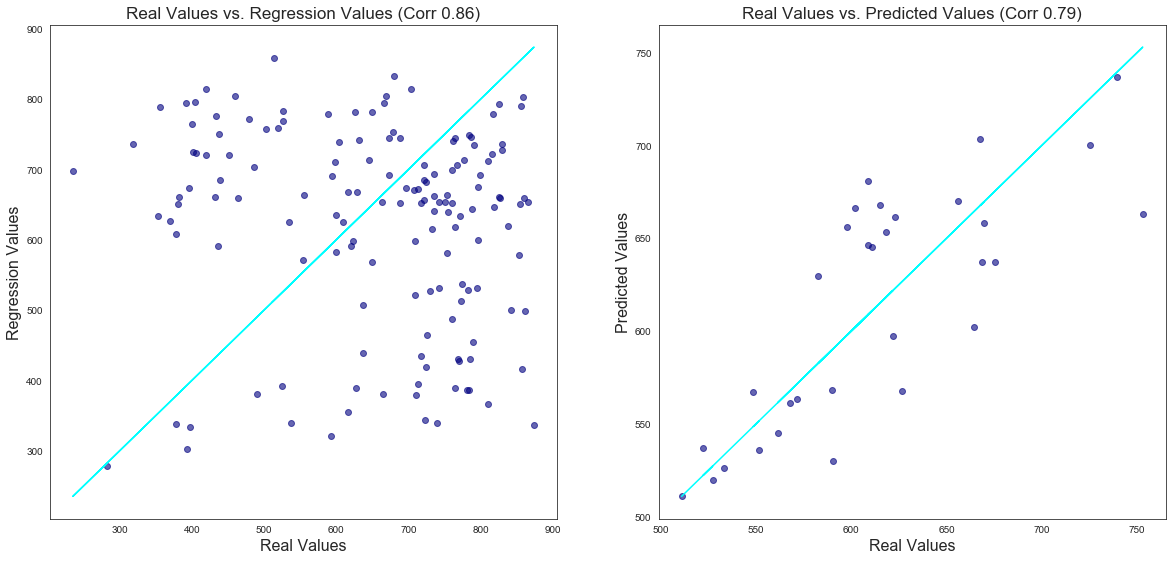

In [262]:
corr_regr = round(np.exp(ypf_logged_train).corr(regr_outlier_treated), 2)
corr_pred = round(ypf_test.corr(pred_outlier_treated), 2)

plt.figure(figsize=(20, 20))

# Graph of Real Values vs. Regression Values
plt.subplot(221)

plt.scatter(x=np.exp(ypf_logged_train), y=regr_outlier_treated, c='navy', alpha=0.6)
plt.plot(ypf_train, ypf_train, color='cyan')

plt.xlabel('Real Values', fontsize=16)
plt.ylabel('Regression Values', fontsize=16)
plt.title(f'Real Values vs. Regression Values (Corr {corr_regr})', fontsize=17)

# Graph of Real Values vs. Predicted Values
plt.subplot(222)

plt.scatter(x=ypf_test, y=pred_outlier_treated, c='navy', alpha=0.6)
plt.plot(ypf_test, ypf_test, color='cyan')

plt.xlabel('Real Values', fontsize=16)
plt.ylabel('Predicted Values', fontsize=16)
plt.title(f'Real Values vs. Predicted Values (Corr {corr_pred})', fontsize=17)

plt.show()

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



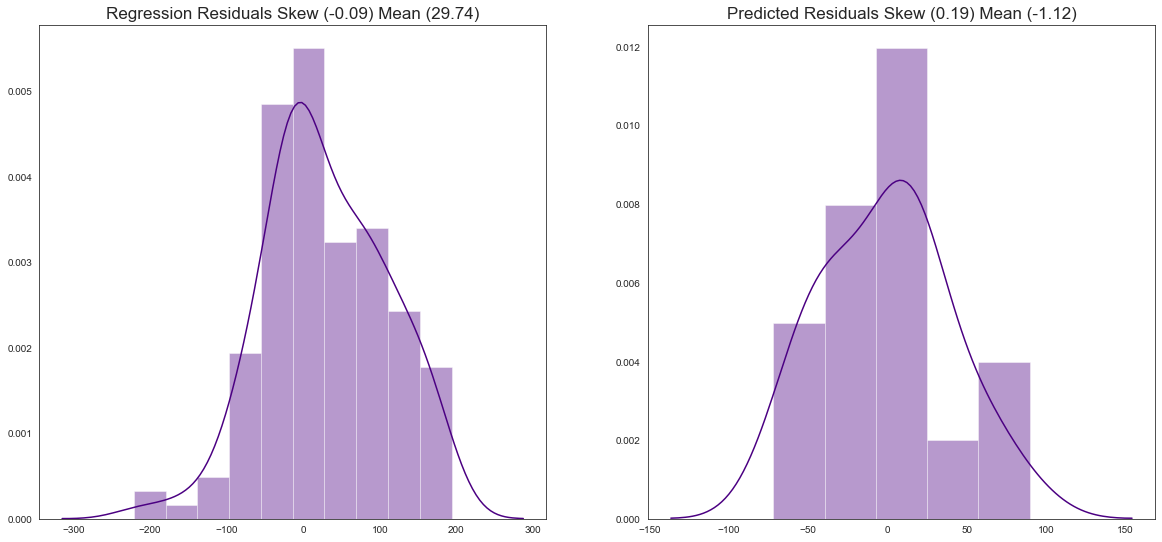

In [263]:
# residual and their stadistics
resid_regr      = np.exp(ypf_logged_train) - regr_outlier_treated
resid_regr_mean = round(resid_regr.mean(),2)
resid_regr_skew = round(resid_regr.skew(),2)

resid_pred      = ypf_test - pred_outlier_treated
resid_pred_mean = round(resid_pred.mean(),2)
resid_pred_skew = round(resid_pred.skew(),2)


plt.figure(figsize=(20, 20))

# Graph of Real Values vs. Regression Values
plt.subplot(221)

sns.distplot(resid_regr, color='indigo')
plt.title(f'Regression Residuals Skew ({resid_regr_skew}) Mean ({resid_regr_mean})', fontsize=17)

# Graph of Real Values vs. Predicted Values
plt.subplot(222)

sns.distplot(resid_pred, color='indigo')
plt.title(f'Predicted Residuals Skew ({resid_pred_skew}) Mean ({resid_pred_mean})', fontsize=17)

plt.show()

# Final Result

In [264]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=regr_outlier_treated.index, y=regr_outlier_treated,
                    mode='lines',
                    name='Regr_v3'))

fig.add_trace(go.Scatter(x=pred_outlier_treated.index, y=pred_outlier_treated,
                    mode='lines',
                    name='Pred_v3'))

fig.add_trace(go.Scatter(x=data.loc['2019-07-01':].index, y=data['YPF'].loc['2019-07-01':],
                    mode='lines',
                    name='Real Values'))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)


fig.show()